# Estadistica descripriva para los sonidos respiratorios


En este notebook se realizó *EDA* en la base de datos icbhi 2017 respiratory sound database disponible en https://bhichallenge.med.auth.gr/

Link de descarga directa [Aqui](https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_final_database.zip)

In [ ]:
! pip install sweetviz

     |████████████████████████████████| 15.1MB 283kB/s 
     |████████████████████████████████| 81kB 6.1MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
# Importar librerias necesarias
import numpy as np 
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import glob
import soundfile
from scipy.io.wavfile import read 
import sweetviz as sv

In [ ]:

import os
for dirname, _, filenames in os.walk('/content/respiratory_sound_database'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# Accedemos a Google drive
direccion = "/content/drive/MyDrive/Sonidos/respiratory-sound-database.zip"
# Se descomprime el archivo
from zipfile import ZipFile 
with ZipFile(direccion, "r") as zip:
  zip.extractall() 
  print("Completado") # Para revisar que se completo la acción

Completado


In [ ]:
# Importamos los archivos necesarios contenidos en Drive
audio_path = '/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files'
demographic_info = '/content/demographic_info.txt'
diagnosis_file = '/content/patient_diagnosis.csv'
text_files = glob.glob('/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/*.txt')

# **2. Analizar el dataset**

In [ ]:
# Funciones necesarias para crear el dataframe, obtener el nombre del archivo, graficar el espectrograma

def get_file_metadata(file_name):
    file_name = file_name.split('/')[-1].replace('.txt', '')
    patient_number, recording_index, chest_location, acquisition_mode, recording_equipment = file_name.split('_')
    return (patient_number, recording_index, chest_location, acquisition_mode, recording_equipment, file_name)

def get_spectogram(audio_file):
    time_series, sample_rate = librosa.load(audio_file)
    stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))
    return librosa.amplitude_to_db(stft, ref=np.max)

for text_file in text_files:
    text_file = text_file.split('/')[-1].replace('.txt', '')
    patient_number, recording_index, chest_location, acquisition_mode, recording_equipment = text_file.split('_')
    #print((patient_number, recording_index, chest_location, acquisition_mode, recording_equipment))
    
files_metadata = [get_file_metadata(file_name) for file_name in text_files]

metadata_df = pd.DataFrame(files_metadata, columns = ['patient_number', 'recording_index', 'chest_location', 'acquisition_mode', 'recording_equipment', 'file_name'])

metadata_df.sort_values('patient_number', inplace=True)
metadata_df['patient_number'] = metadata_df['patient_number'].astype(int)

metadata_df.head()

,patient_number,recording_index,chest_location,acquisition_mode,recording_equipment,file_name
205,101,1b1,Al,sc,Meditron,101_1b1_Al_sc_Meditron
713,101,1b1,Pr,sc,Meditron,101_1b1_Pr_sc_Meditron
441,102,1b1,Ar,sc,Meditron,102_1b1_Ar_sc_Meditron
448,103,2b2,Ar,mc,LittC2SE,103_2b2_Ar_mc_LittC2SE
332,104,1b1,Pr,sc,Litt3200,104_1b1_Pr_sc_Litt3200


In [ ]:
# Se ve las filas y colomnas del Df
metadata_df.shape

(920, 6)

In [ ]:
# Locación de medidas hechas por los equipos de grabación
for equipment in metadata_df['recording_equipment'].unique():
    locations = np.sort(metadata_df.loc[metadata_df['recording_equipment'] == 'Meditron']['chest_location'].unique())
    print(f"{equipment}: {locations}")

Meditron: ['Al' 'Ar' 'Ll' 'Lr' 'Pl' 'Pr' 'Tc']
LittC2SE: ['Al' 'Ar' 'Ll' 'Lr' 'Pl' 'Pr' 'Tc']
Litt3200: ['Al' 'Ar' 'Ll' 'Lr' 'Pl' 'Pr' 'Tc']
AKGC417L: ['Al' 'Ar' 'Ll' 'Lr' 'Pl' 'Pr' 'Tc']


In [ ]:
# Conteo de las grabaciones por equipo usado
equipo_grabacion_df = metadata_df.groupby('recording_equipment').count()
equipo_grabacion_df = equipo_grabacion_df.rename(columns = {'patient_number': 'count'})[['count']]
equipo_grabacion_df.reset_index(inplace=True)
equipo_grabacion_df

,recording_equipment,count
0,AKGC417L,646
1,Litt3200,60
2,LittC2SE,87
3,Meditron,127


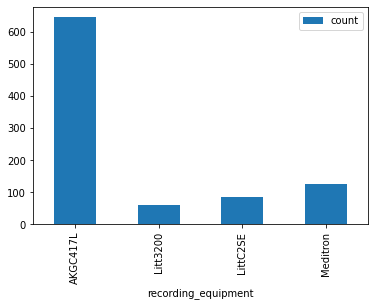

In [ ]:
# Gráfica conteo del uso segun equipo de grabación
equipo_grabacion_df.plot(kind='bar', x='recording_equipment', y='count');

In [ ]:
# En este bloque de codigo se unen para crear un nuevo Df más organizado y con los Header en español
caracteristicas_demograficas = [
    'numero_paciente',
    'edad',
    'genero',
    'IMC_adultos',
    'peso_niños',
    'altura_niños'
]
caracteristicas_df = pd.read_csv(demographic_info, header=None, delimiter=' ')
caracteristicas_df.columns = caracteristicas_demograficas
caracteristicas_df['edad'].fillna(caracteristicas_df['edad'].median(), inplace=True)
caracteristicas_df['grupo_edad'] = caracteristicas_df['edad'].apply(lambda n: int(n/10)*10)
print(caracteristicas_df.shape)
caracteristicas_df.head()

(126, 7)


,numero_paciente,edad,genero,IMC_adultos,peso_niños,altura_niños,grupo_edad
0,101,3.00,F,NaN,19.0,99.0,0
1,102,0.75,F,NaN,9.8,73.0,0
2,103,70.00,F,33.00,NaN,NaN,70
3,104,70.00,F,28.47,NaN,NaN,70
4,105,7.00,F,NaN,32.0,135.0,0


In [ ]:
# Numero de paciente con su respectivo diagnostico
diagnostico_df = pd.read_csv(diagnosis_file, header=None)
diagnostico_df.columns = ['numero_paciente', 'diagnostico']
print(diagnostico_df.shape)
diagnostico_df.head()

(126, 2)


,numero_paciente,diagnostico
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
# Se revisa el diagnostico de un paciente en especifico
diagnostico_df.loc[diagnostico_df['numero_paciente']==152]

,numero_paciente,diagnostico
51,152,Healthy


In [ ]:
# Se revisa el tipo de variable
diagnostico_df.dtypes

numero_paciente     int64
diagnostico        object
dtype: object

In [ ]:
# Se revisa el tipo de variable
caracteristicas_df.dtypes

numero_paciente      int64
edad               float64
genero              object
IMC_adultos        float64
peso_niños         float64
altura_niños       float64
grupo_edad           int64
dtype: object

In [ ]:
# Se unen los dos csv para tener las caracteristicas y el diagnostico en el mismo df
caracteristicas_diagnostico_df = pd.merge(caracteristicas_df, diagnostico_df)
print(caracteristicas_diagnostico_df.shape)
caracteristicas_diagnostico_df.head()

(126, 8)


,numero_paciente,edad,genero,IMC_adultos,peso_niños,altura_niños,grupo_edad,diagnostico
0,101,3.00,F,NaN,19.0,99.0,0,URTI
1,102,0.75,F,NaN,9.8,73.0,0,Healthy
2,103,70.00,F,33.00,NaN,NaN,70,Asthma
3,104,70.00,F,28.47,NaN,NaN,70,COPD
4,105,7.00,F,NaN,32.0,135.0,0,URTI


In [ ]:
# Guardamos el dataframe en csv y en txt
caracteristicas_diagnostico_df.to_csv(index=False)

In [ ]:

caracteristicas_diagnostico_df.to_csv ('/content/export_dataframe.csv', index = False, header=True)


# **3. Análisis usando SweetViz**

In [ ]:
# Se leen los archivos de diagnostico y caracteristicas demograficas
# caracteristicas_diagnostico_df es la variable de nuestro dataframe unido
diagnosticos =pd.read_csv("/content/patient_diagnosis.csv", header=None, delimiter=' ' )
caracteristicas = "/content/demographic_info.txt"


In [ ]:
# Se imprime el encabezado 
caracteristicas_diagnostico_df.head (5)

,numero_paciente,edad,genero,IMC_adultos,peso_niños,altura_niños,grupo_edad,diagnostico
0,101,3.00,F,NaN,19.0,99.0,0,URTI
1,102,0.75,F,NaN,9.8,73.0,0,Healthy
2,103,70.00,F,33.00,NaN,NaN,70,Asthma
3,104,70.00,F,28.47,NaN,NaN,70,COPD
4,105,7.00,F,NaN,32.0,135.0,0,URTI


In [ ]:
# Se hace el análisis con la libreria y se imprime en formato html
analyze_report = sv.analyze(caracteristicas_diagnostico_df)
analyze_report.show_html('analisis.html', open_browser=False)

                                             |          | [  0%]   00:00 -> (? left)

Report analisis.html was generated.



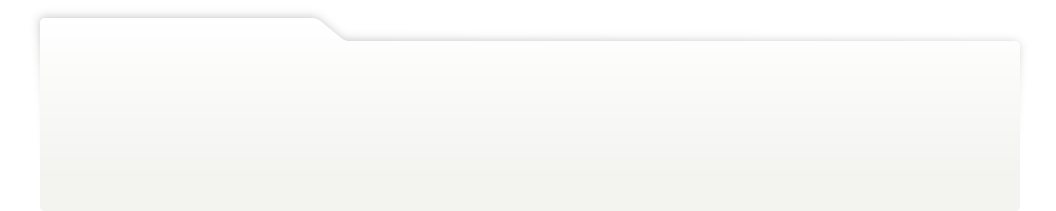
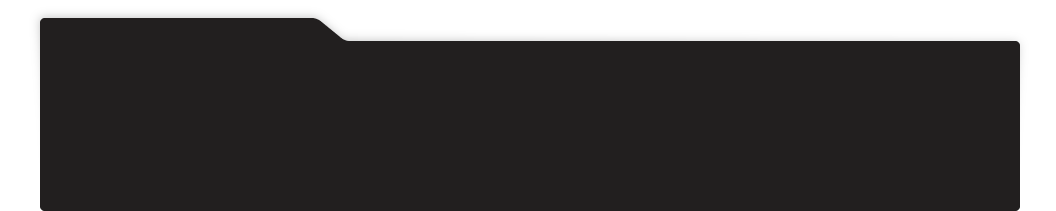
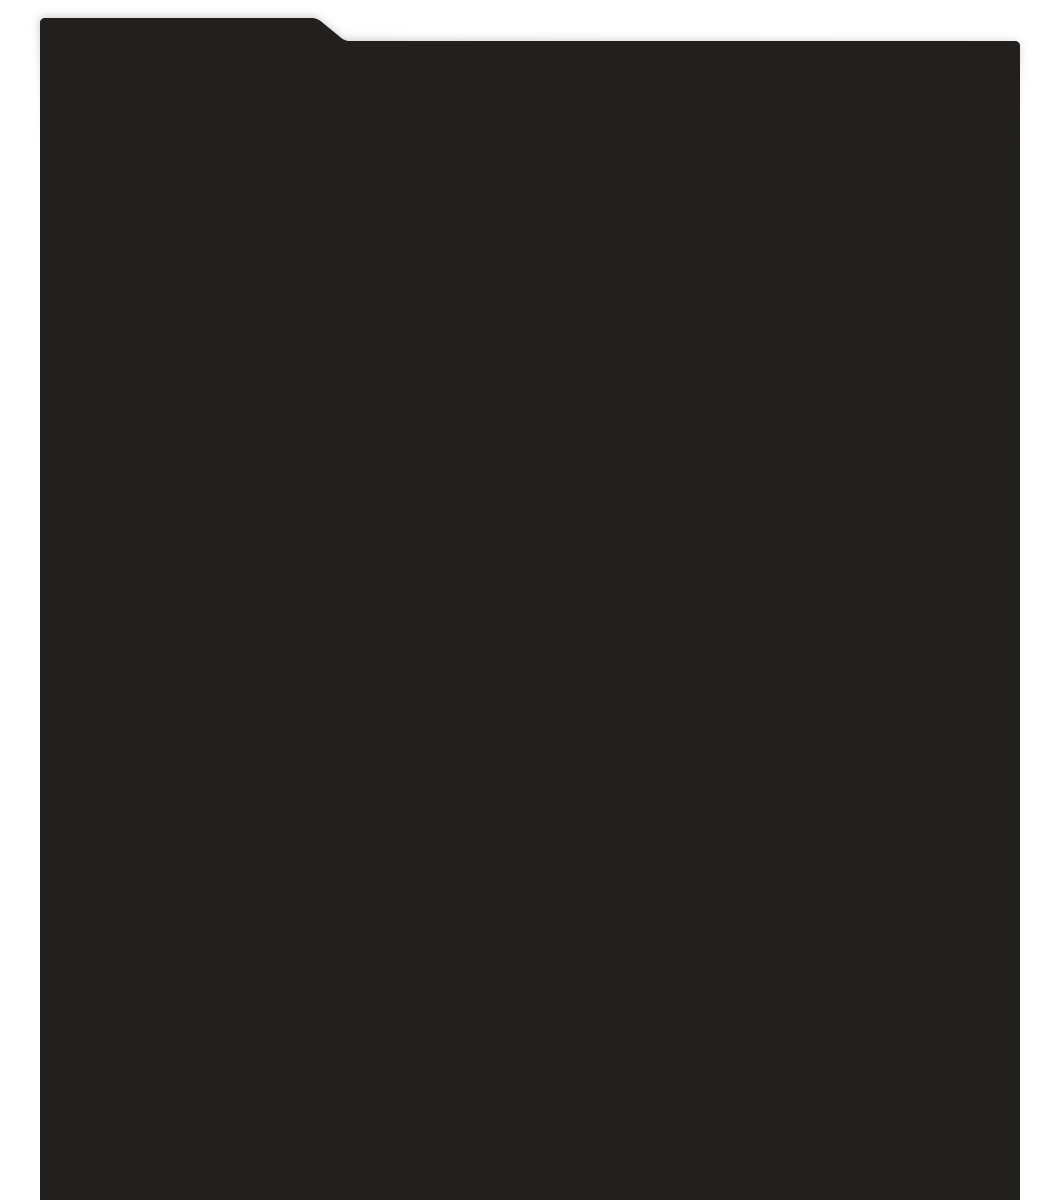
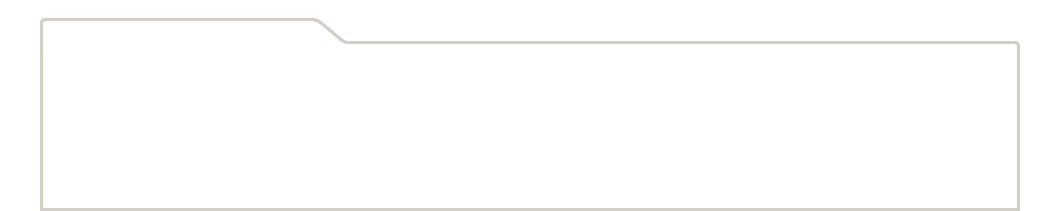
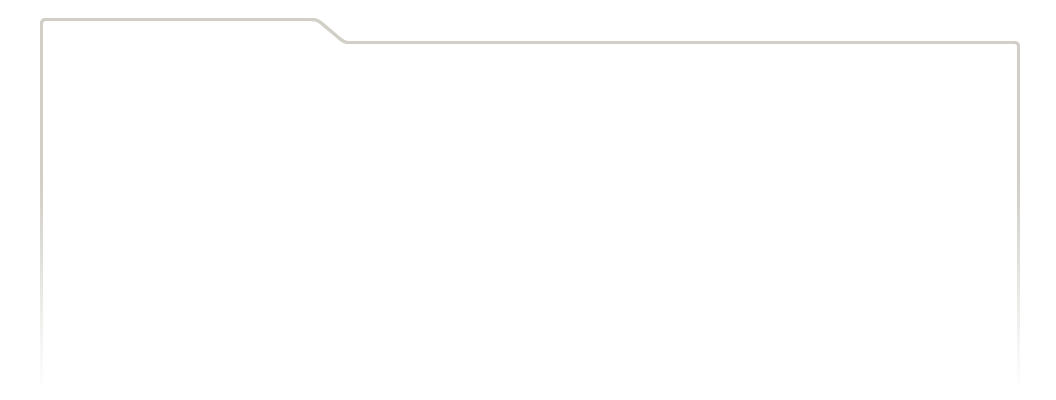
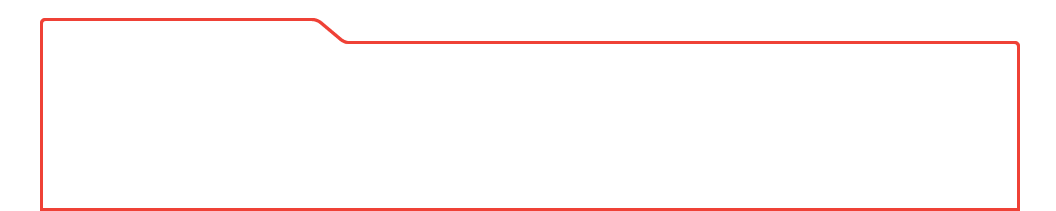
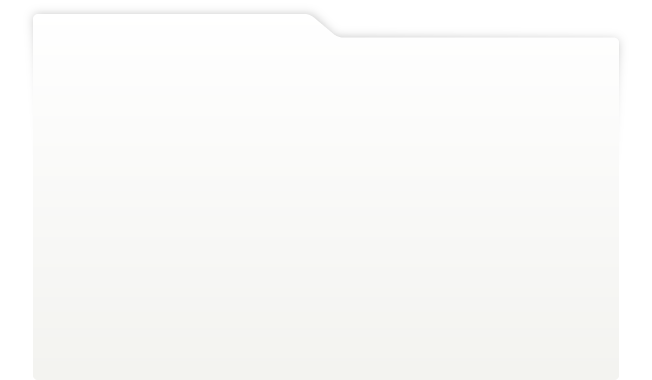
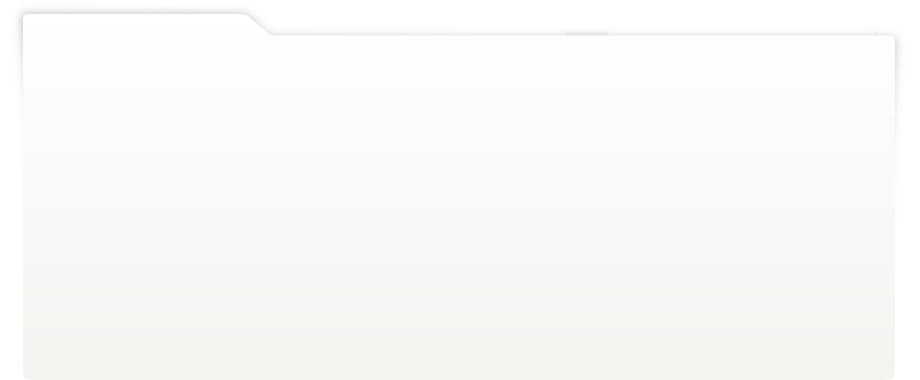
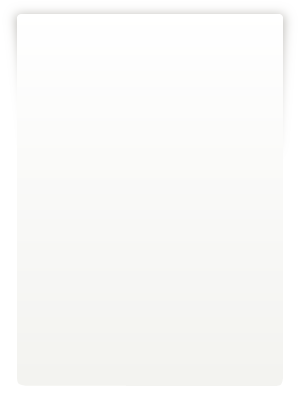
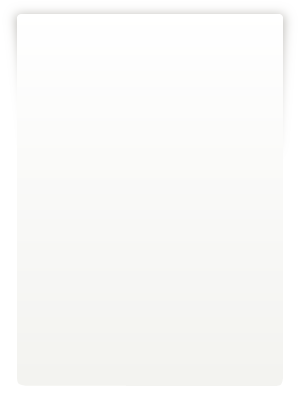
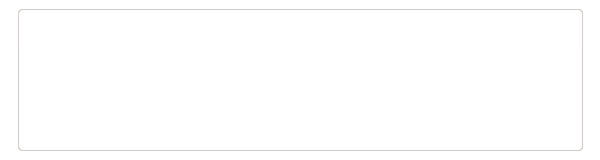
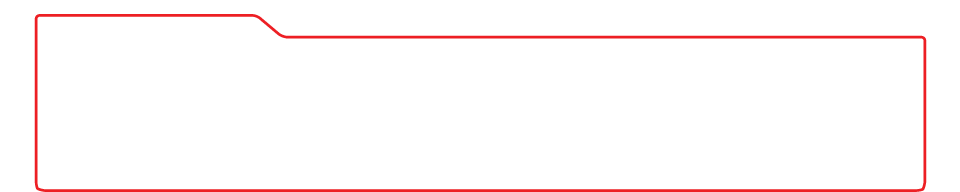
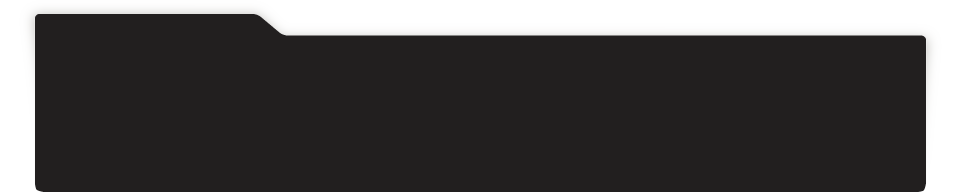
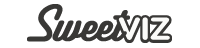
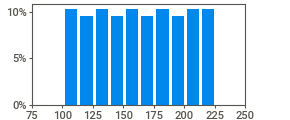
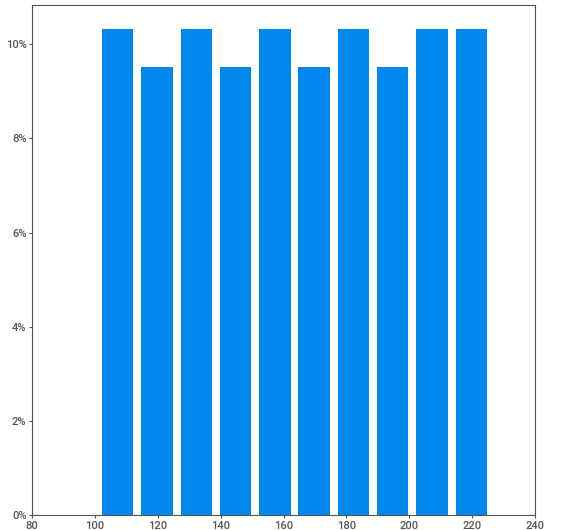
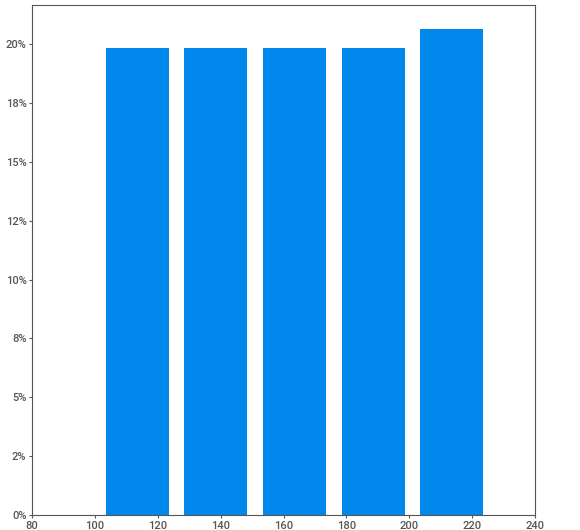
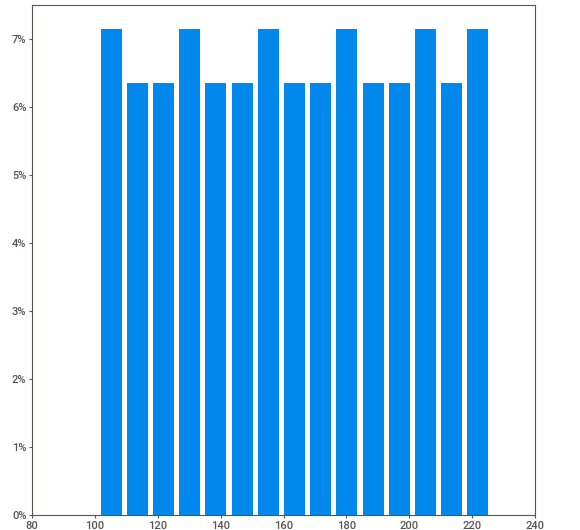
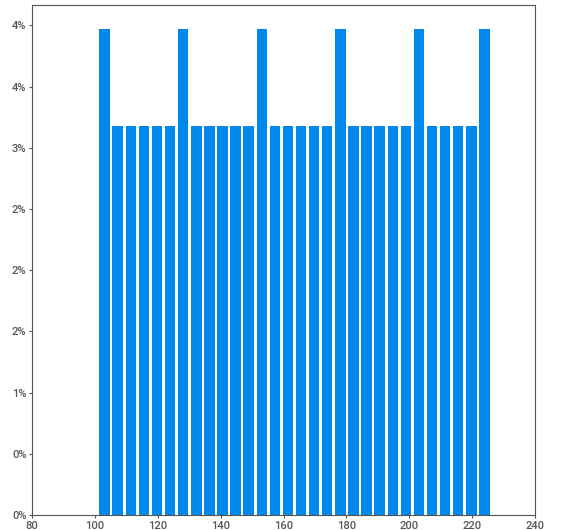
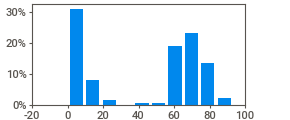
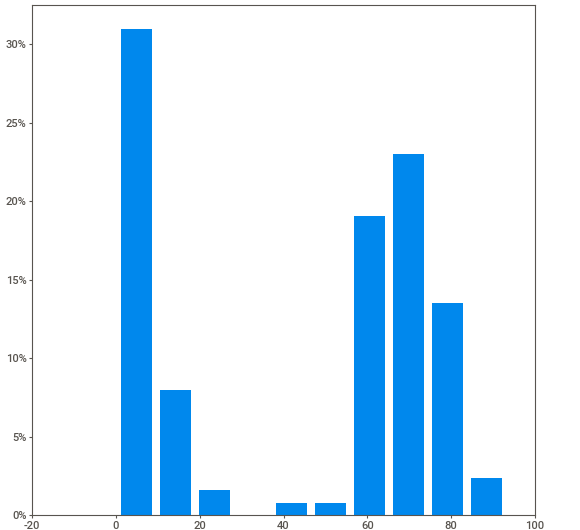
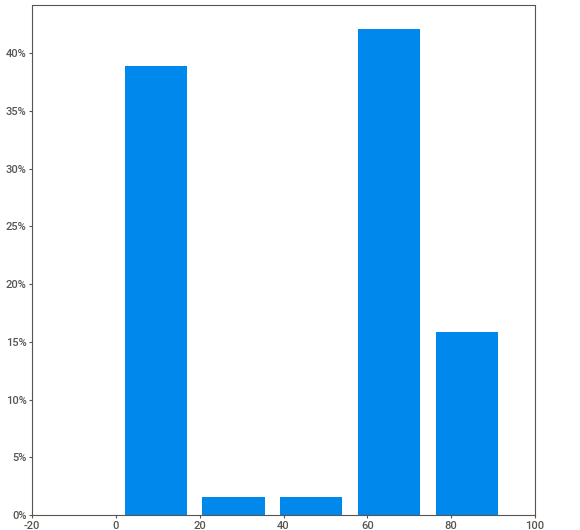
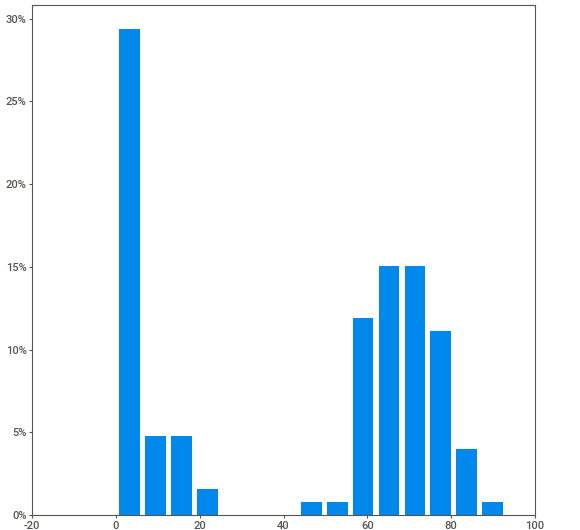
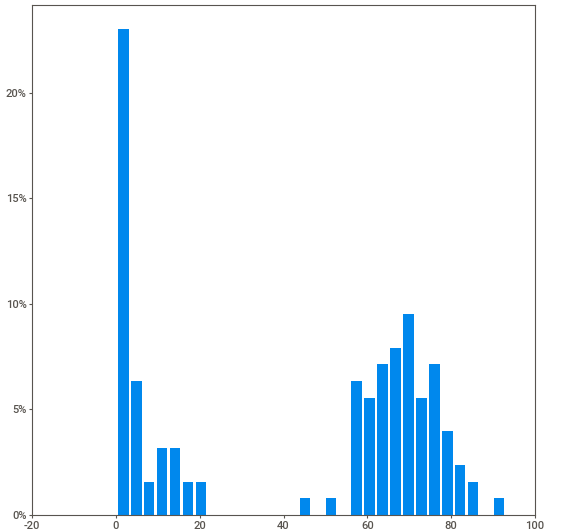
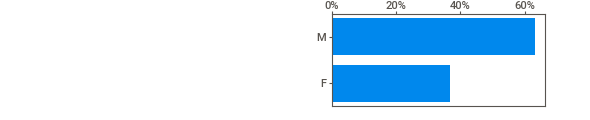
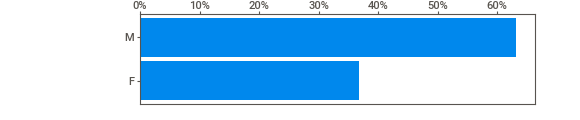
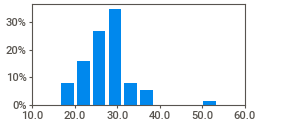
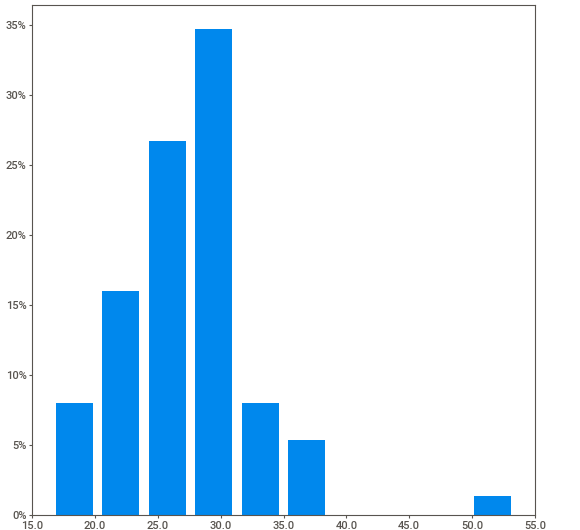
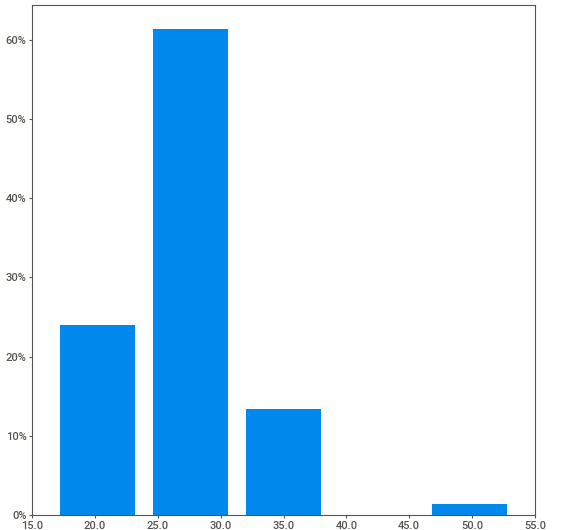
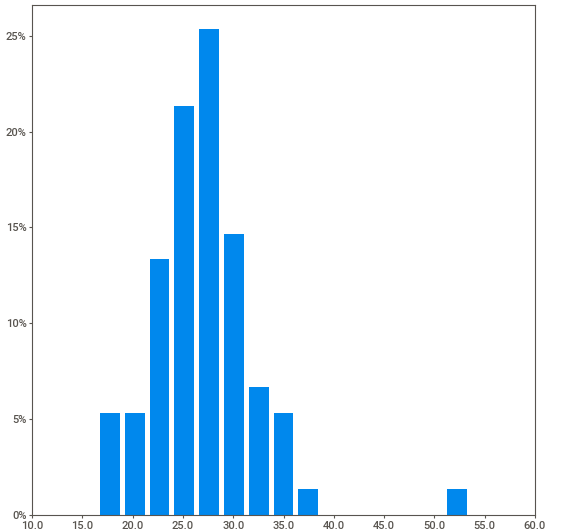
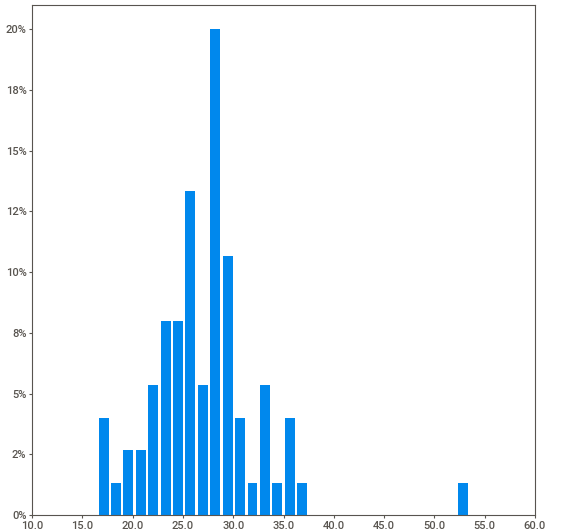
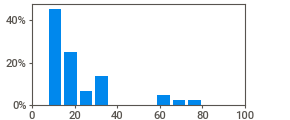
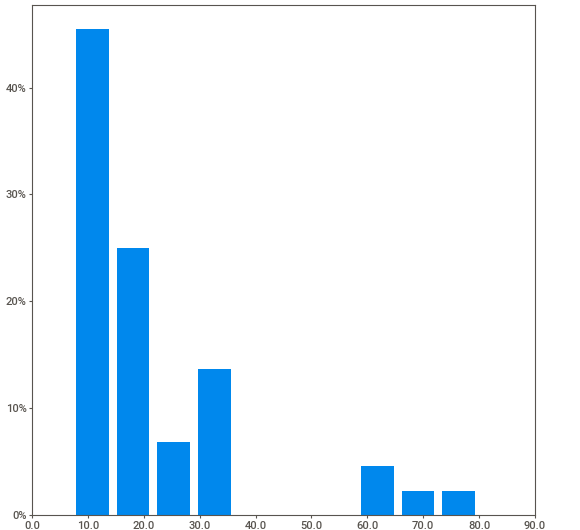
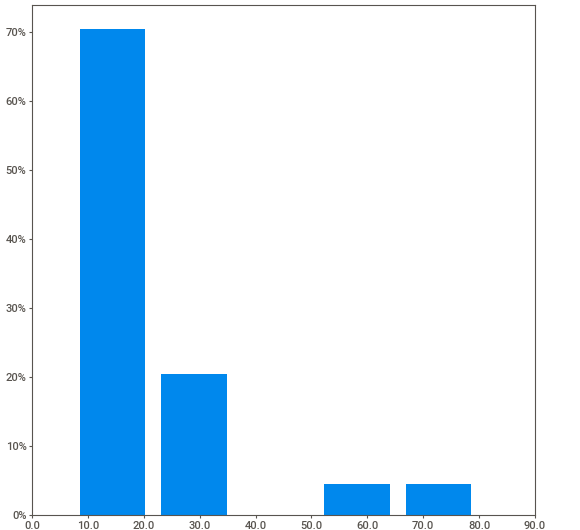
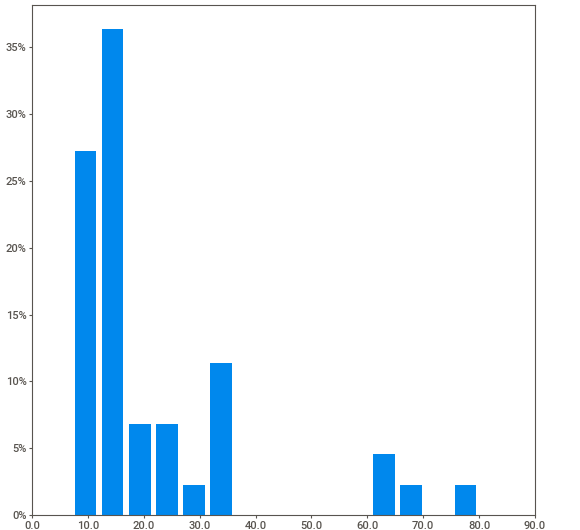
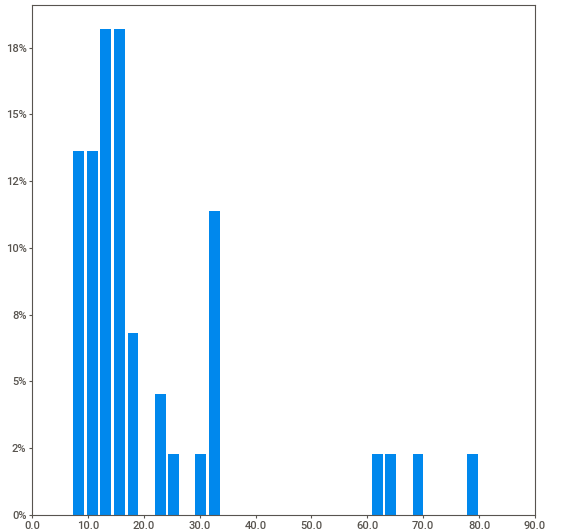
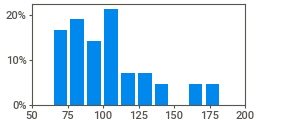
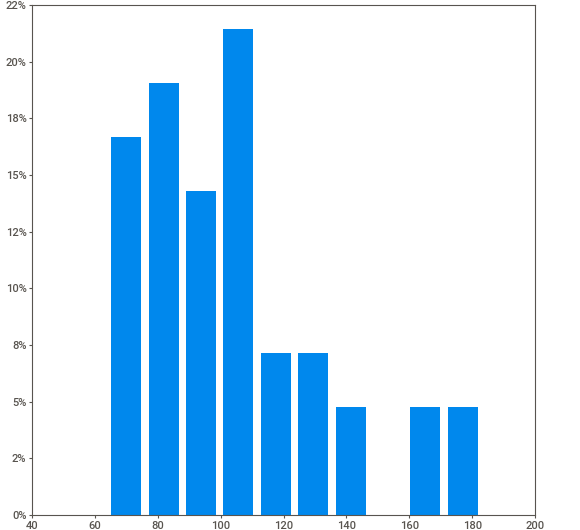
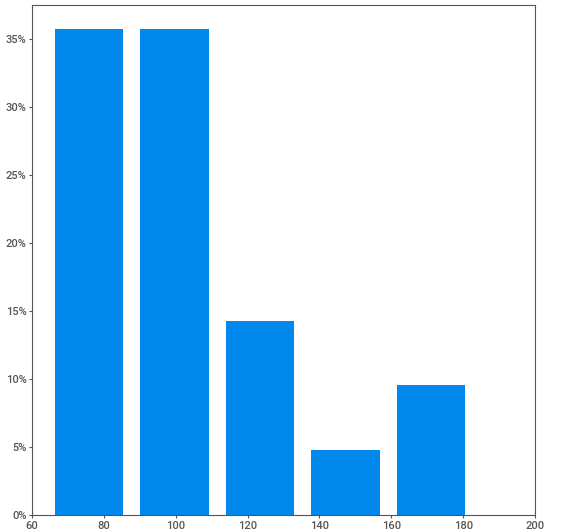
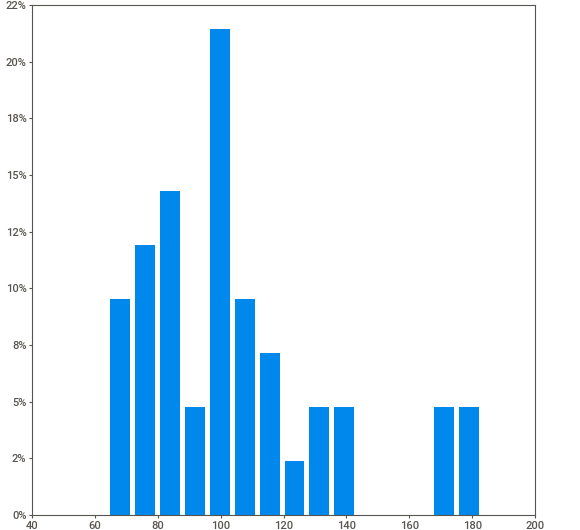
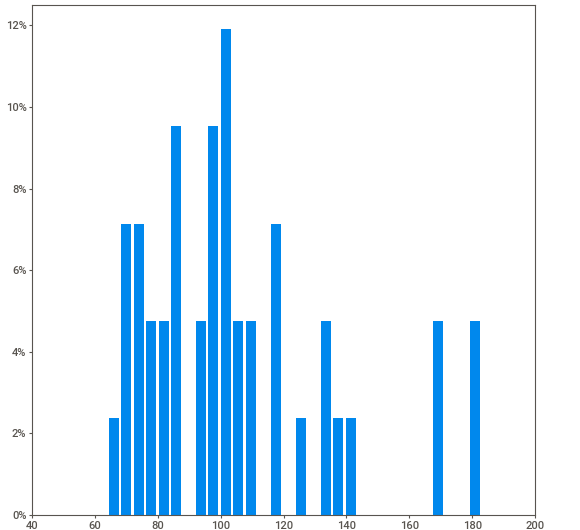
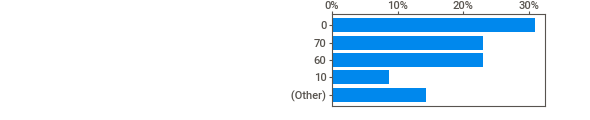
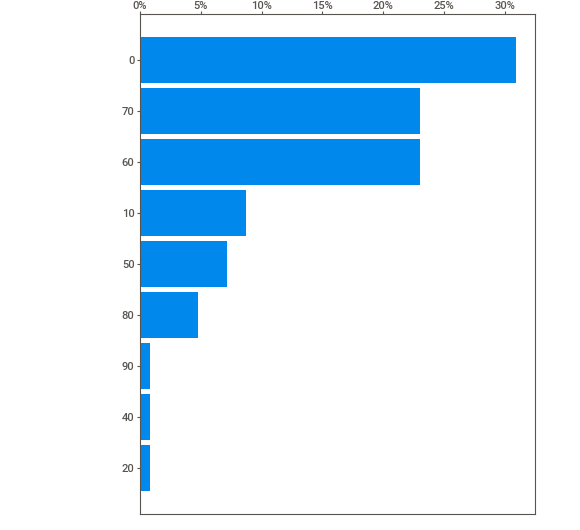
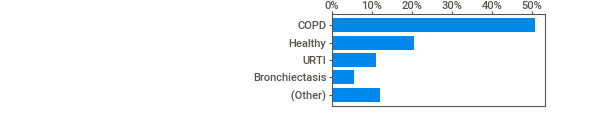
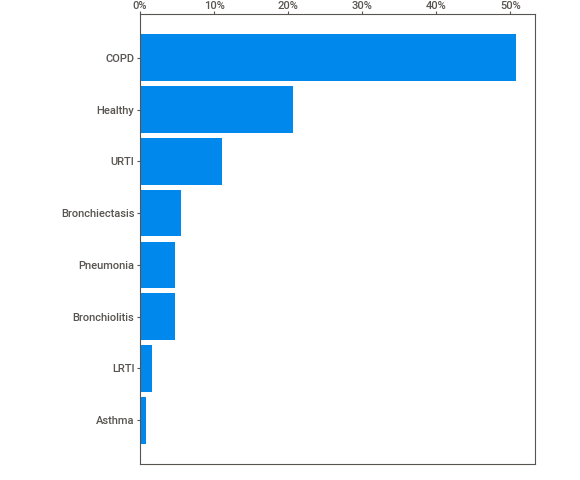
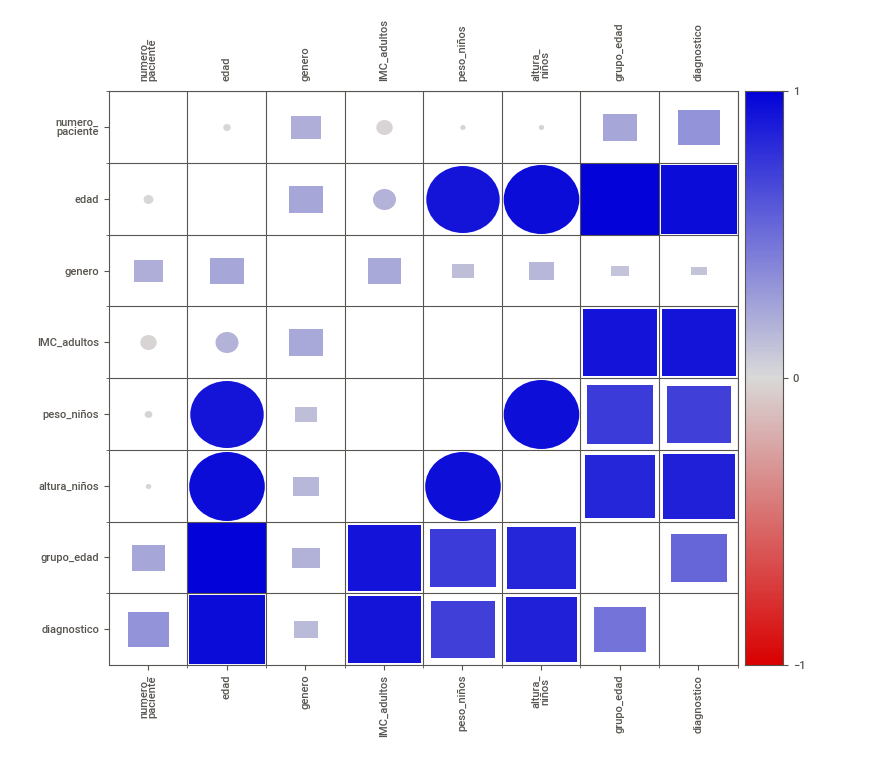
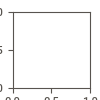

In [ ]:
# Se imprime el reporte para poder visualizaralo en el notebook
import IPython
IPython.display.HTML('analisis.html')

# Otras caracteristicas

In [ ]:
# Se revisa el Df
dataframe= caracteristicas_diagnostico_df
dataframe.head()

,numero_paciente,edad,genero,IMC_adultos,peso_niños,altura_niños,grupo_edad,diagnostico
0,101,3.00,F,NaN,19.0,99.0,0,URTI
1,102,0.75,F,NaN,9.8,73.0,0,Healthy
2,103,70.00,F,33.00,NaN,NaN,70,Asthma
3,104,70.00,F,28.47,NaN,NaN,70,COPD
4,105,7.00,F,NaN,32.0,135.0,0,URTI


In [ ]:
# Se revisa la distribución de enfermedades para cada genero
mujeres_enfermedad = dataframe.groupby(["genero",'diagnostico']).size()
mujeres_enfermedad

genero  diagnostico   
F       Asthma             1
        Bronchiectasis     5
        Bronchiolitis      2
        COPD              15
        Healthy           13
        Pneumonia          2
        URTI               8
M       Bronchiectasis     2
        Bronchiolitis      4
        COPD              48
        Healthy           13
        LRTI               2
        Pneumonia          4
        URTI               6
dtype: int64

In [ ]:
# Se revisa la distribución de enfermedades para cada genero
edad = dataframe.groupby(["edad",'diagnostico']).size()
edad

edad   diagnostico  
0.25   Healthy          1
0.50   Healthy          1
0.58   LRTI             1
0.67   Bronchiolitis    1
       URTI             1
                       ..
81.00  Pneumonia        1
83.00  COPD             1
84.00  COPD             1
85.00  COPD             1
93.00  COPD             1
Length: 70, dtype: int64